#### **6. Predicting Next Purchase Day(How soon each customer can visit the store (0-30 days, 30-60 days, 60-90 days, 90+ days)**
- For this, we need create dependent variable at customer level (average days per one transaction for only repeat customers and divide into groups 0-30 days, 30-60 days,  60-90 days and 90+ days) then build classification model to predict next purchase of given customer.

In [1]:
# import required libraries 
import pandas as pd 
import numpy as np 
import joblib
import pickle
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import  RobustScaler ,StandardScaler
from sklearn.metrics import  confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import  DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the customer data aggregated in previous problems 
customer_data = pd.read_csv('customer_sales_data.csv')
customer_data.head()

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value
0,12346,Apparel,4.648500,1.500000,1.000000,31,F,New York,108,1,174.98174,174.981740,0.000681,3.380480
1,12347,Nest-USA,64.697850,5.700000,0.333333,20,M,New York,60,31,12090.29580,390.009542,0.021117,150.692217
2,12348,Office,13.026870,9.086957,0.478261,39,M,California,74,8,1501.92620,187.740775,0.005450,36.503718
3,12350,Apparel,24.001235,1.235294,0.352941,25,M,California,18,11,1183.71394,107.610358,0.007493,18.442113
4,12356,Apparel,12.020583,1.555556,0.305556,31,F,Chicago,108,13,1753.45086,134.880835,0.008856,33.874991


In [3]:
# online sales data 
sales_df = pd.read_csv('online_sales_final.csv')
# customer segmentation 
rfm_segments = pd.read_csv('rfm_segments.csv')

In [4]:
# insepct rfm data 
rfm_segments.head()

,customer_id,recency,frequency,monetary_value,customer_tier
563,14606,1,289,56727.87067,Premium
736,15311,13,291,76540.74430,Premium
643,14911,11,276,51725.14647,Premium
1355,17841,18,263,49397.24444,Premium
850,15808,2,123,24017.17750,Premium


In [5]:
# format  datatype  of transaction date
sales_df['transaction_date'] = pd.to_datetime(sales_df['transaction_date'])

In [6]:
# calcualte first and last transaction date by each customer. 
transaction_info = sales_df.groupby('customer_id').agg(
    first_purchase_date = ('transaction_date', 'min'),
    last_purchase_date = ('transaction_date', 'max')
).reset_index()
transaction_info.head()

,customer_id,first_purchase_date,last_purchase_date
0,12346,2019-09-15,2019-09-15
1,12347,2019-03-24,2019-11-02
2,12348,2019-06-22,2019-10-19
3,12350,2019-12-14,2019-12-14
4,12356,2019-09-15,2019-09-15


In [7]:
# merge transaction date information anb rfm values with customer data. 
customer_data = pd.merge(customer_data, transaction_info, on='customer_id')
customer_data = pd.merge(customer_data, rfm_segments[['customer_id', 'customer_tier']], on='customer_id')
customer_data.head()

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value,first_purchase_date,last_purchase_date,customer_tier
0,12346,Apparel,4.648500,1.500000,1.000000,31,F,New York,108,1,174.98174,174.981740,0.000681,3.380480,2019-09-15,2019-09-15,Standard
1,12347,Nest-USA,64.697850,5.700000,0.333333,20,M,New York,60,31,12090.29580,390.009542,0.021117,150.692217,2019-03-24,2019-11-02,Premium
2,12348,Office,13.026870,9.086957,0.478261,39,M,California,74,8,1501.92620,187.740775,0.005450,36.503718,2019-06-22,2019-10-19,Silver
3,12350,Apparel,24.001235,1.235294,0.352941,25,M,California,18,11,1183.71394,107.610358,0.007493,18.442113,2019-12-14,2019-12-14,Silver
4,12356,Apparel,12.020583,1.555556,0.305556,31,F,Chicago,108,13,1753.45086,134.880835,0.008856,33.874991,2019-09-15,2019-09-15,Silver


We calculate average days between transactions ( dividing total number of transactions by total number of days customer made transactions )

In [8]:
# single day customers 
single_day_customers = len(customer_data[customer_data['first_purchase_date'] == customer_data['last_purchase_date']])
# single day customer proportion among customers with more than 1 transactions
print(f" Percentage of single day transaction customers :{(single_day_customers / len(customer_data)) * 100 : 0.2f} %")

 Percentage of single day transaction customers : 50.00 %


In [9]:
# calculate average days between transactions. 
customer_data['avg_days_between_transactions'] = (customer_data['last_purchase_date'] - customer_data['first_purchase_date']).dt.days / customer_data['frequency']
# repeat customers (more than one transactions) and not a single day transactions. 
repeat_customers = customer_data[customer_data['first_purchase_date'] != customer_data['last_purchase_date']]
# display 5 rows 
repeat_customers.head()

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value,first_purchase_date,last_purchase_date,customer_tier,avg_days_between_transactions
1,12347,Nest-USA,64.697850,5.700000,0.333333,20,M,New York,60,31,12090.29580,390.009542,0.021117,150.692217,2019-03-24,2019-11-02,Premium,7.193548
2,12348,Office,13.026870,9.086957,0.478261,39,M,California,74,8,1501.92620,187.740775,0.005450,36.503718,2019-06-22,2019-10-19,Silver,14.875000
6,12370,Apparel,15.850484,6.736264,0.230769,21,F,New York,190,44,6749.99632,153.409007,0.029973,88.337831,2019-05-26,2019-06-25,Gold,0.681818
8,12377,Apparel,21.163844,5.467532,0.272727,27,F,California,41,37,9848.12188,266.165456,0.025204,165.707086,2019-07-05,2019-11-21,Premium,3.756757
9,12383,Apparel,8.053957,2.681159,0.304348,32,M,New York,100,39,5478.60846,140.477140,0.026567,109.255710,2019-07-13,2019-09-23,Gold,1.846154


In [10]:
# customers with avg daays between transaction more than 90 
repeat_customers[repeat_customers['avg_days_between_transactions'] > 90]

,customer_id,favourite_category,discount_per_order,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,recency,frequency,monetary_value,avg_order_value,purchase_frequency,lifetime_value,first_purchase_date,last_purchase_date,customer_tier,avg_days_between_transactions
531,14496,Apparel,10.126368,1.526316,0.473684,47,F,California,28,3,682.88611,227.628703,0.002044,20.001844,2019-01-13,2019-12-04,Standard,108.333333


We have only one sample with `more than 90 days` class so we can drop that category for training classification. 


In [11]:
# define funtion 
def next_purchase(x):
    if x.avg_days_between_transactions < 30:          # expected purchase 0-30 days 
        return 0 
    elif 30 <= x.avg_days_between_transactions < 60:   # expected purchase 30-60 days 
        return 1
    else:
        return 2                                      # expected purchase more than 60 days 

In [12]:
# apply the mapping to create classes. 
repeat_customers['expected_txn'] = repeat_customers.apply(next_purchase, axis=1)

In [13]:
# class distribution 
repeat_customers['expected_txn'].value_counts()

0    700
1     26
2      8
Name: expected_txn, dtype: int64

In [14]:
# drop redundant columns for model training.
cols_to_drop = ['favourite_category', 'first_purchase_date', 'last_purchase_date',  'avg_days_between_transactions', 'purchase_frequency']
repeat_customers.drop(columns=cols_to_drop, axis=1, inplace=True)

In [15]:
# features and target seperation 
X = repeat_customers.drop(['customer_id', 'expected_txn'], axis=1)
y = repeat_customers['expected_txn']


In [16]:
# encode ordinal categorical features 
# tier map 
customer_tier = {
    'Premium':3,
    'Gold': 2,
    'Silver': 1,
    'Standard': 0
}
X['customer_tier_enc'] = X['customer_tier'].map(customer_tier)
X.drop('customer_tier', axis=1, inplace=True)


In [17]:
# encode nominal features 
X = pd.get_dummies(X, columns=['location', 'gender'], drop_first=True)

Resampling to handle class imbalance 

In [18]:
# Check the class distribution before resampling
print("Class distribution before resampling: \n", Counter(y))
# Use SMOTE with Tomeklinks
smote_tomek = SMOTETomek(sampling_strategy={1: 100, 2: 50}, random_state=42)
# Resample the data
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
# Check the class distribution after resampling
print("Class distribution after resampling: \n", Counter(y_resampled))

Class distribution before resampling: 
 Counter({0: 700, 1: 26, 2: 8})
Class distribution after resampling: 
 Counter({0: 692, 1: 93, 2: 49})


Train-Test Split

In [19]:
# train test splt 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
X_train.shape, X_test.shape 

((667, 15), (167, 15))

**Model Training**

We use `XGBClassifier` to train the classification model. 

Model: CatBoostClassifier
Accuracy: 0.9701
Precision: 0.9732
Recall: 0.9701
F1 Score: 0.9710
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       138
           1       0.82      0.95      0.88        19
           2       1.00      1.00      1.00        10

    accuracy                           0.97       167
   macro avg       0.94      0.97      0.95       167
weighted avg       0.97      0.97      0.97       167



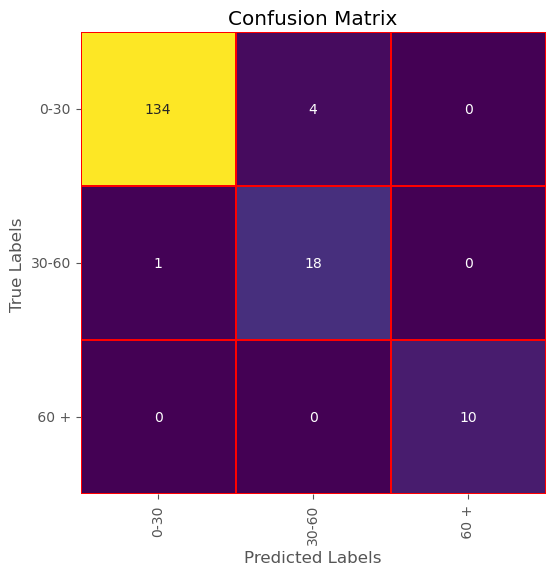

In [20]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier()

# fit the model on the training data
xgb_clf.fit(X_train, y_train)
# Use the trained model to make predictions on the test data
y_pred = xgb_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics for each model
print("Model: CatBoostClassifier")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# calcualte confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Mapping of classes to their corresponding names
class_names = ['0-30', '30-60', ' 60 +']
# Display the confusion matrix with centered ticks
plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=0.3, linecolor='red', cmap='viridis', cbar=False)

# Set the ticks at the center of each square
ax.set_xticks(np.arange(len(class_names)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(class_names)) + 0.5, minor=False)

# Set the tick labels
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Hyperparameter Tuning**

Best Hyperparameters: {'learning_rate': 0.5, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'scale_pos_weight': 1}
Accuracy: 0.9701
Precision: 0.9732
Recall: 0.9701
F1 Score: 0.9710


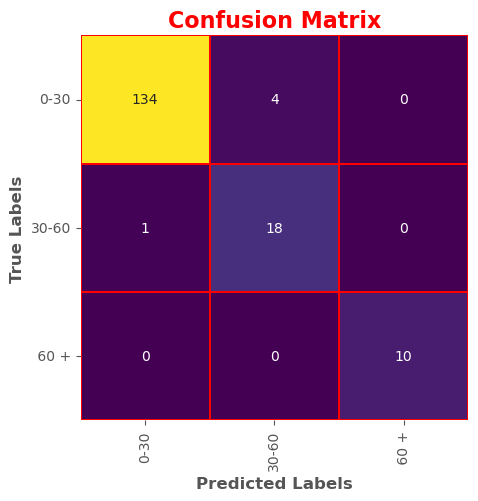

In [21]:
# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'n_estimators': [30, 40, 50],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 2, 3]
}

# Create an XGBoost classifier
xgb_clf = XGBClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
# Calculate evaluation metrics
accuracy_best = accuracy_score(y_test, y_pred)
precision_best = precision_score(y_test, y_pred, average='weighted')
recall_best = recall_score(y_test, y_pred, average='weighted')
f1_best = f1_score(y_test, y_pred, average='weighted')

# Print the results
print("Best Hyperparameters:", best_params)

# Print the evaluation metrics for each model
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")

# calcualte confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Mapping of classes to their corresponding names
class_names = ['0-30', '30-60', ' 60 +']
# Display the confusion matrix with centered ticks
plt.figure(figsize=(5, 5))
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=0.3, linecolor='red', cmap='viridis', cbar=False)

# Set the ticks at the center of each square
ax.set_xticks(np.arange(len(class_names)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(class_names)) + 0.5, minor=False)

# Set the tick labels
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

# Set labels and title
plt.xlabel('Predicted Labels' , weight='bold')
plt.ylabel('True Labels', weight='bold')
plt.title('Confusion Matrix', weight='bold', fontsize=16, color='r')
plt.show()


In [22]:
# save the model as pickle
model_filename = 'expected_purchase_classification.pkl'
joblib.dump('xgb_clf', model_filename)

['expected_purchase_classification.pkl']